# Cell 1: Load and Inspect Data

In [1]:
import pandas as pd

# Load dataset
df = pd.read_csv("/kaggle/input/massive-yahoo-finance-dataset/stock_details_5_years.csv")

# Display first 5 rows and dataset info
print("First 5 Rows of Dataset:")
print(df.head())
print("\nDataset Info:")
print(df.info())

First 5 Rows of Dataset:
                        Date        Open        High         Low       Close  \
0  2018-11-29 00:00:00-05:00   43.829761   43.863354   42.639594   43.083508   
1  2018-11-29 00:00:00-05:00  104.769074  105.519257  103.534595  104.636131   
2  2018-11-29 00:00:00-05:00   54.176498   55.007500   54.099998   54.729000   
3  2018-11-29 00:00:00-05:00   83.749496   84.499496   82.616501   83.678497   
4  2018-11-29 00:00:00-05:00   39.692784   40.064904   38.735195   39.037853   

      Volume  Dividends  Stock Splits Company  
0  167080000       0.00           0.0    AAPL  
1   28123200       0.00           0.0    MSFT  
2   31004000       0.00           0.0   GOOGL  
3  132264000       0.00           0.0    AMZN  
4   54917200       0.04           0.0    NVDA  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 602962 entries, 0 to 602961
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -

# Cell 2: Data Preprocessing

In [2]:
import pandas as pd
import numpy as np

# Define companies list
companies = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA']

# Parse 'Date' column to datetime, removing timezone info
df['Date'] = pd.to_datetime(df['Date'], utc=True).dt.tz_localize(None)

# Filter for selected companies
df = df[df['Company'].isin(companies)].reset_index(drop=True)

# Handle missing values
print("Missing Values Before Cleaning:\n", df.isnull().sum())
df = df.dropna()  # Drop rows with any missing values

# Check and remove duplicate dates per company
duplicates = df.groupby(['Company', 'Date']).size().reset_index(name='count')
print("Duplicate Dates per Company:\n", duplicates[duplicates['count'] > 1])
df = df.drop_duplicates(subset=['Company', 'Date'], keep='first')

# Sort by Company and Date
df = df.sort_values(['Company', 'Date']).reset_index(drop=True)

# Display preprocessed data
print("\nPreprocessed Data (First 5 Rows):")
print(df.head())

Missing Values Before Cleaning:
 Date            0
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
Company         0
dtype: int64
Duplicate Dates per Company:
 Empty DataFrame
Columns: [Company, Date, count]
Index: []

Preprocessed Data (First 5 Rows):
                 Date       Open       High        Low      Close     Volume  \
0 2018-11-29 05:00:00  43.829761  43.863354  42.639594  43.083508  167080000   
1 2018-11-30 05:00:00  43.261071  43.270671  42.478826  42.850754  158126000   
2 2018-12-03 05:00:00  44.261681  44.376858  43.481835  44.348064  163210000   
3 2018-12-04 05:00:00  43.419445  43.764977  42.296468  42.397247  165377200   
4 2018-12-06 05:00:00  41.214280  41.938938  40.892744  41.924541  172393600   

   Dividends  Stock Splits Company  
0        0.0           0.0    AAPL  
1        0.0           0.0    AAPL  
2        0.0           0.0    AAPL  
3        0.0           0.0    AAPL  
4  

# Cell 3: Calculate Technical Indicators

In [3]:
import pandas as pd
import numpy as np
import warnings

# Suppress RuntimeWarnings for cleaner output
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Function to calculate technical indicators
def calculate_indicators(df, company):
    company_df = df[df['Company'] == company].copy()
    company_df['Close'] = pd.to_numeric(company_df['Close'], errors='coerce')
    company_df = company_df.dropna(subset=['Close'])
    
    # SMA_20
    company_df['SMA_20'] = company_df['Close'].rolling(window=20).mean()
    # EMA_20
    company_df['EMA_20'] = company_df['Close'].ewm(span=20, adjust=False).mean()
    # RSI_14
    delta = company_df['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    company_df['RSI_14'] = 100 - (100 / (1 + rs))
    # Bollinger Bands
    rolling_mean = company_df['Close'].rolling(window=20).mean()
    rolling_std = company_df['Close'].rolling(window=20).std()
    company_df['BB_upper'] = rolling_mean + 2 * rolling_std
    company_df['BB_lower'] = rolling_mean - 2 * rolling_std
    
    return company_df

# List of companies
companies = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA']

# Calculate indicators
df_with_indicators = pd.concat([calculate_indicators(df, company) for company in companies])

# Verify output
print("Data with Indicators (First 5 Rows for AAPL):")
print(df_with_indicators[df_with_indicators['Company'] == 'AAPL'].head())

Data with Indicators (First 5 Rows for AAPL):
                 Date       Open       High        Low      Close     Volume  \
0 2018-11-29 05:00:00  43.829761  43.863354  42.639594  43.083508  167080000   
1 2018-11-30 05:00:00  43.261071  43.270671  42.478826  42.850754  158126000   
2 2018-12-03 05:00:00  44.261681  44.376858  43.481835  44.348064  163210000   
3 2018-12-04 05:00:00  43.419445  43.764977  42.296468  42.397247  165377200   
4 2018-12-06 05:00:00  41.214280  41.938938  40.892744  41.924541  172393600   

   Dividends  Stock Splits Company  SMA_20     EMA_20  RSI_14  BB_upper  \
0        0.0           0.0    AAPL     NaN  43.083508     NaN       NaN   
1        0.0           0.0    AAPL     NaN  43.061341     NaN       NaN   
2        0.0           0.0    AAPL     NaN  43.183886     NaN       NaN   
3        0.0           0.0    AAPL     NaN  43.108968     NaN       NaN   
4        0.0           0.0    AAPL     NaN  42.996165     NaN       NaN   

   BB_lower  
0       

# Cell 4: Rule-Based Anomaly Detection

In [4]:
import pandas as pd
import numpy as np

# Clean NaN indicators
df_clean = df_with_indicators.dropna(subset=['SMA_20', 'EMA_20', 'RSI_14', 'BB_upper', 'BB_lower'])

# Define rule-based anomaly detection
def detect_rule_anomalies(df):
    df = df.copy()
    df['Rule_Anomaly'] = 0
    # RSI extremes
    df.loc[(df['RSI_14'] > 70) | (df['RSI_14'] < 30), 'Rule_Anomaly'] = 1
    # Outside Bollinger Bands
    df.loc[(df['Close'] > df['BB_upper']) | (df['Close'] < df['BB_lower']), 'Rule_Anomaly'] = 1
    # >5% deviation from SMA_20
    deviation = abs(df['Close'] - df['SMA_20']) / df['SMA_20']
    df.loc[deviation > 0.05, 'Rule_Anomaly'] = 1
    return df

# Apply rule-based detection
df_with_rule_anomalies = detect_rule_anomalies(df_clean)

# Display results
print("Dataset Info After Cleaning and Rule-Based Anomaly Detection:")
print(df_with_rule_anomalies.info())
print("\nRule-Based Anomaly Counts:")
print(df_with_rule_anomalies['Rule_Anomaly'].value_counts())
print("\nFirst 5 Rows with Rule-Based Anomalies for AAPL:")
print(df_with_rule_anomalies[(df_with_rule_anomalies['Company'] == 'AAPL') & (df_with_rule_anomalies['Rule_Anomaly'] == 1)].head())

Dataset Info After Cleaning and Rule-Based Anomaly Detection:
<class 'pandas.core.frame.DataFrame'>
Index: 6195 entries, 19 to 6289
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          6195 non-null   datetime64[ns]
 1   Open          6195 non-null   float64       
 2   High          6195 non-null   float64       
 3   Low           6195 non-null   float64       
 4   Close         6195 non-null   float64       
 5   Volume        6195 non-null   int64         
 6   Dividends     6195 non-null   float64       
 7   Stock Splits  6195 non-null   float64       
 8   Company       6195 non-null   object        
 9   SMA_20        6195 non-null   float64       
 10  EMA_20        6195 non-null   float64       
 11  RSI_14        6195 non-null   float64       
 12  BB_upper      6195 non-null   float64       
 13  BB_lower      6195 non-null   float64       
 14  Rule_Anomaly  6195 non-null   

# Cell 5: Isolation Forest Anomaly Detection

In [5]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import pickle

# Use cleaned data from Cell 4
df = df_with_rule_anomalies.copy()

# Features for Isolation Forest
features = ['Close', 'SMA_20', 'EMA_20', 'RSI_14', 'BB_upper', 'BB_lower']
X = df[features]

# Scale features
scaler_iso = StandardScaler()
X_scaled = scaler_iso.fit_transform(X)

# Train Isolation Forest with higher contamination
iso_forest = IsolationForest(contamination=0.1, random_state=42)  # Changed from 0.05 to 0.1
df['IF_Anomaly'] = iso_forest.fit_predict(X_scaled)
df['IF_Anomaly'] = df['IF_Anomaly'].apply(lambda x: 1 if x == -1 else 0)

# Display results
print("Isolation Forest Anomaly Counts per Company:")
print(df.groupby('Company')['IF_Anomaly'].sum())

# Save model and scaler
with open('/kaggle/working/iso_forest_model.pkl', 'wb') as f:
    pickle.dump((iso_forest, scaler_iso), f)
print("Isolation Forest model saved to '/kaggle/working/iso_forest_model.pkl'")

Isolation Forest Anomaly Counts per Company:
Company
AAPL      59
AMZN       0
GOOGL      0
MSFT     251
NVDA     310
Name: IF_Anomaly, dtype: int64
Isolation Forest model saved to '/kaggle/working/iso_forest_model.pkl'


# Cell 6: Prepare LSTM Sequences

In [6]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np

# Function to create LSTM sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Normalize data for all companies
scaler = MinMaxScaler()
features_to_scale = ['Close']
scaled_data = scaler.fit_transform(df[features_to_scale])

# Prepare sequences per company
seq_length = 20
company_sequences = {}
for company in companies:
    company_df = df[df['Company'] == company]
    company_close = company_df['Close'].values.reshape(-1, 1)
    scaled_company_close = scaler.transform(company_close)
    X, y = create_sequences(scaled_company_close, seq_length)
    company_sequences[company] = (X, y)

# Verify AAPL sequences
print("AAPL Sequence Shapes:", company_sequences['AAPL'][0].shape, company_sequences['AAPL'][1].shape)

AAPL Sequence Shapes: (1219, 20, 1) (1219, 1)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


# Cell 7: Visualize Anomalies

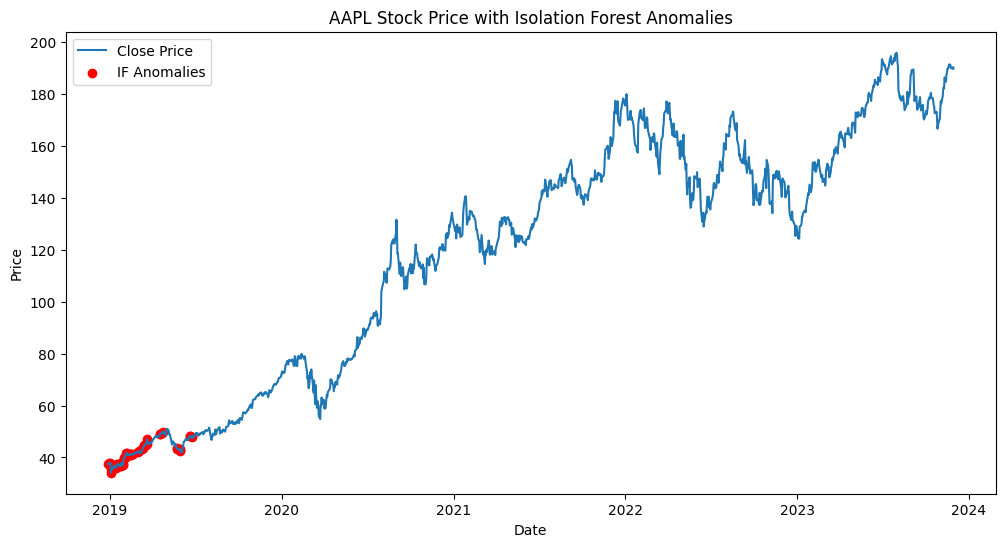

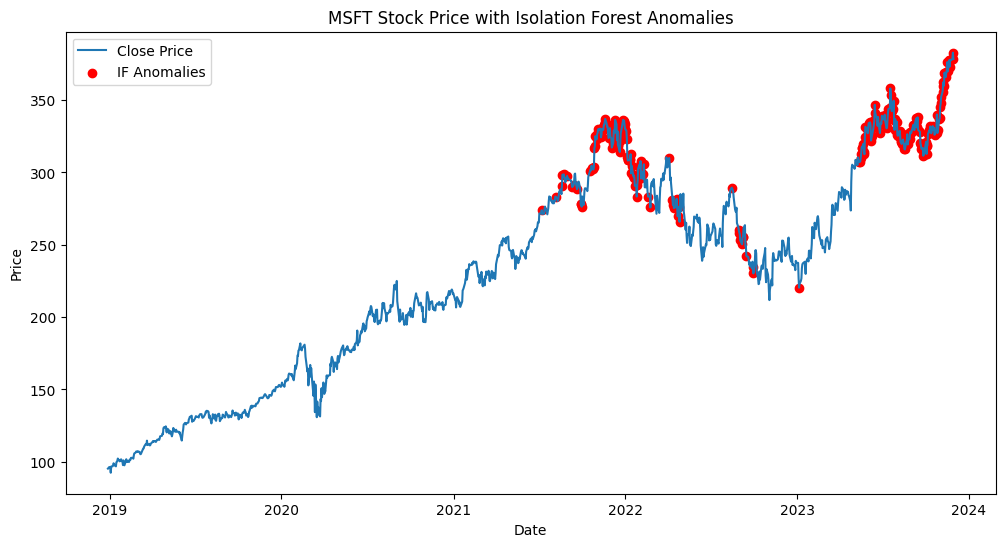

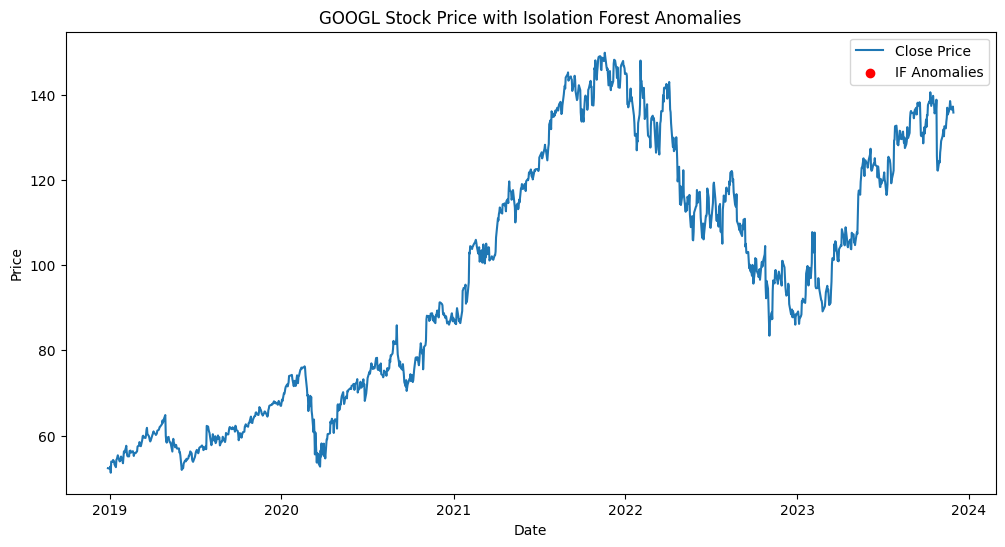

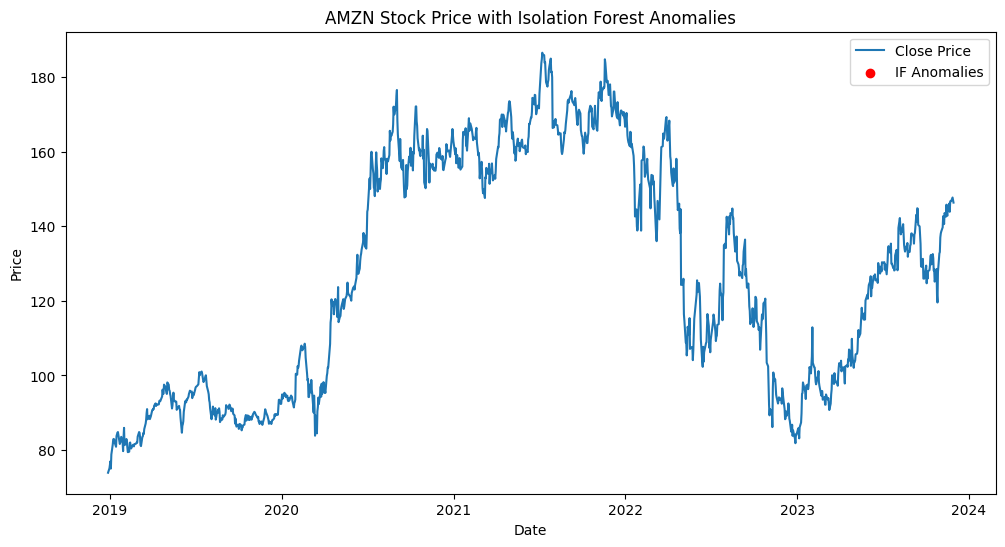

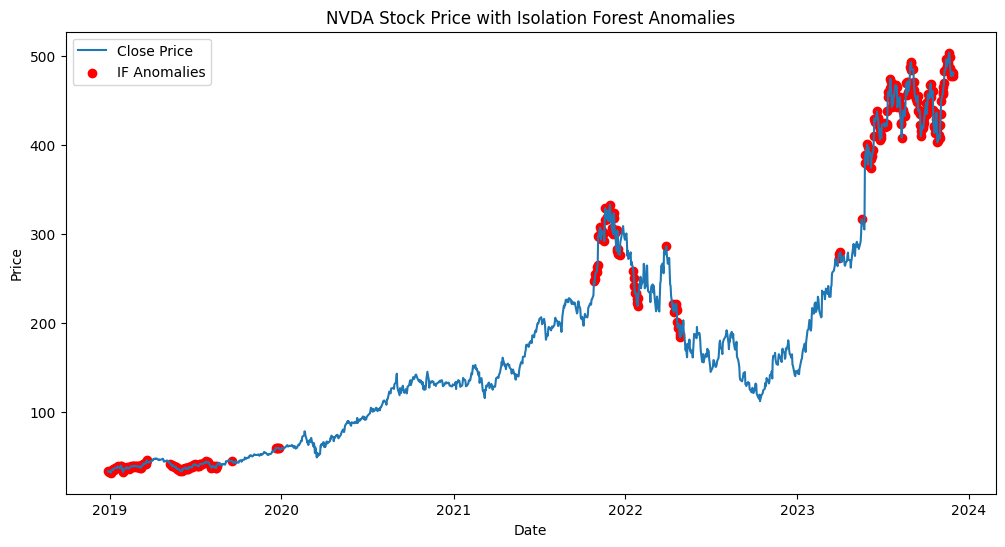

In [7]:
import matplotlib.pyplot as plt

# Function to plot anomalies
def plot_anomalies(company_df, company):
    plt.figure(figsize=(12, 6))
    plt.plot(company_df['Date'], company_df['Close'], label='Close Price')
    anomalies = company_df[company_df['IF_Anomaly'] == 1]
    plt.scatter(anomalies['Date'], anomalies['Close'], color='red', label='IF Anomalies')
    plt.title(f'{company} Stock Price with Isolation Forest Anomalies')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Plot for each company
for company in companies:
    company_df = df[df['Company'] == company]
    plot_anomalies(company_df, company)

# Cell 8: Train and Predict with LSTM (with Logging and Checkpoints)

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Epoch 1/50
27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0188
Epoch 1: val_loss improved from inf to 0.00023, saving model to /kaggle/working/lstm_AAPL_checkpoint.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0171 - val_loss: 2.2838e-04
Epoch 2/50
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.0893e-04
Epoch 2: val_loss improved from 0.00023 to 0.00019, saving model to /kaggle/working/lstm_AAPL_checkpoint.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.8593e-04 - val_loss: 1.8925e-04
Epoch 3/50
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6210e-04
Epoch 3: val_loss did not improve from 0.00019
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6158e-04 - val_loss: 3.0971e-04
Epoch 4/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7165e-04
Epoch 4: val_loss did not improve from 0.00019
31/31 ━━━━━━━━━━━━━━━━━━━━ 

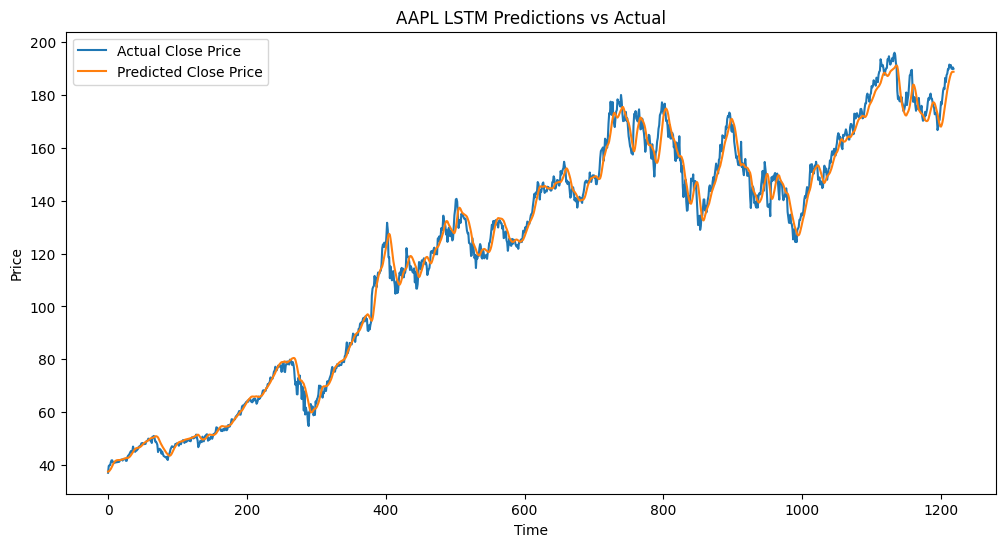

Final LSTM model saved to '/kaggle/working/lstm_AAPL_final.keras'


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import logging

# Confirm GPU availability
gpus = tf.config.list_physical_devices('GPU')
print(f"Available GPUs: {gpus}")

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')
logger = logging.getLogger()

# Pick AAPL for training and inference
company = 'AAPL'
X, y = company_sequences[company]

# Define LSTM model with Input layer
lstm_model = Sequential([
    Input(shape=(seq_length, 1)),
    LSTM(50, return_sequences=True),
    LSTM(50),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')

# Define callbacks for logging, checkpoints, and early stopping
checkpoint_path = f"/kaggle/working/lstm_{company}_checkpoint.keras"
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',  # Monitor validation loss
    save_best_only=True,
    mode='min',
    verbose=1
)
tensorboard = TensorBoard(log_dir=f"/kaggle/working/logs_{company}", histogram_freq=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

# Train model with validation split
logger.info(f"Starting LSTM training for {company}")
history = lstm_model.fit(
    X, y,
    epochs=50,
    batch_size=32,
    validation_split=0.2,  # Use 20% of data for validation
    callbacks=[checkpoint, tensorboard, early_stopping],
    verbose=1
)
logger.info(f"LSTM training completed for {company}")

# Predict
y_pred = lstm_model.predict(X, verbose=0)

# Inverse transform
y_inv = scaler.inverse_transform(y.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_inv, label='Actual Close Price')
plt.plot(y_pred_inv, label='Predicted Close Price')
plt.title(f'{company} LSTM Predictions vs Actual')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Save final model
lstm_model.save(f'/kaggle/working/lstm_{company}_final.keras')
print(f"Final LSTM model saved to '/kaggle/working/lstm_{company}_final.keras'")

# Cell 9: Evaluate Results

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pickle

# Evaluate LSTM for AAPL
company = 'AAPL'
X, y = company_sequences[company]
y_pred = lstm_model.predict(X, verbose=0)
y_inv = scaler.inverse_transform(y.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

rmse = np.sqrt(mean_squared_error(y_inv, y_pred_inv))
mae = mean_absolute_error(y_inv, y_pred_inv)
print(f"RMSE for {company} LSTM Predictions: {rmse:.2f}")
print(f"MAE for {company} LSTM Predictions: {mae:.2f}")

# Load Isolation Forest and evaluate on test set
with open('/kaggle/working/iso_forest_model.pkl', 'rb') as f:
    iso_forest, scaler_iso = pickle.load(f)
test_df = df[df['Company'] == company].iloc[-len(X):]
test_features = scaler_iso.transform(test_df[features])
test_anomalies = iso_forest.predict(test_features)
print(f"Number of IF Anomalies in {company} Test Set: {(test_anomalies == -1).sum()}")

# Check anomalies in full AAPL dataset for context
full_aapl_df = df[df['Company'] == company]
full_features = scaler_iso.transform(full_aapl_df[features])
full_anomalies = iso_forest.predict(full_features)
print(f"Number of IF Anomalies in Full {company} Dataset: {(full_anomalies == -1).sum()}")

RMSE for AAPL LSTM Predictions: 4.10
MAE for AAPL LSTM Predictions: 3.02
Number of IF Anomalies in AAPL Test Set: 39
Number of IF Anomalies in Full AAPL Dataset: 59
